### Project and data are based on a free, online course of machine learning https://www.coursera.org/learn/machine-learning. I wholeheartedly recommend this! 

## I will show how do it in Python:
    + neural networks,
    + forward and backward propagation,
    + visualization of hidden units.


In [1]:
import numpy as np
import pandas
import scipy.io
import matplotlib.pyplot as plt
import random
from scipy.optimize import minimize
import math 
import warnings
import sys

# ignore warnings
warnings.filterwarnings('ignore')

# write packages and python version to file
! python -m pip list > packages_versions.txt
# a append to file
with open('packages_versions.txt', 'a') as f:
    f.write('Python version ' + str(sys.version))


In [2]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

def sigmoid_gradient(z):
    '''
    Returns gradient of sigmoid function.
    '''
    return sigmoid(z) * (1 - sigmoid(z))

def con_ones(X):
    m = len(X)
    ones = np.ones((m,1))
    return np.concatenate((ones, X), 1)


def predict(X, *thetas):
    '''
    Predicts class for given thetas.
    '''
    i = 0
    m = X.shape[0]
    for theta in thetas:
        if i != 0:
            X = sigmoid(X)           
        X = con_ones(X)
        X = X @ theta.T
        i += 1            
    hx = sigmoid(X)
    pred = np.argmax(hx, axis = 1)
    pred = np.reshape((pred + 1),(m,1))
    return pred

def plot_numbers(X, size, range_):
    z = np.ones((20*size + size - 1, 20*size + size - 1))
    choosed = random.sample(range(range_), size ** 2)
    for no_pic in range(size ** 2):
        pic = X[choosed[no_pic]]
        x, y = divmod(no_pic, size)
        for i in range(400):
            d, r = divmod(i,20)
            z[r + 20*x + x][d + 20*y + y] = pic[i]
    if size == 1:
        return z, choosed[0]
    else:
        return z
    
def pack(flat_theta, layers):
    '''
    Changes flat array to list of arrays, which shapes are from layers.
    '''
    sub_thetas = []
    from_ = 0
    for no_theta in range(1, len(layers)):     
        prev = layers[no_theta - 1] + 1
        cur = layers[no_theta]
        temp = flat_theta[from_:from_ + prev*cur]
        temp = np.reshape(temp, (cur, prev), 'F')
        sub_thetas.append(temp)
        from_ += prev*cur        
    return sub_thetas 
        
        
cost_history = []
def gradient_cost_fun(flat_theta, X,Y, lambda_, layers):
    '''
    Computes cost function and gradient for neural network,
    using forward and backward propagation.
    Provides cost history.
    '''
    global cost_history
    thetas = pack(flat_theta, layers)
    
    #forward propagation
    Z = {}
    A = {}  
    i = 0
    reg = 0
    for theta in thetas:
        reg += np.sum(theta[:,1:]**2)
        if i != 0:
            X = sigmoid(X)
        X = con_ones(X)
        A[i+1] = X
        X = X @ theta.T
        Z[i+2] = X
        i += 1
        
    A[i+1] = sigmoid(X)     
    h_theta = A[i+1]
    reg = lambda_/(2*m) * reg      
    no_reg = np.sum(-Y.T * np.log(h_theta) - (1-Y.T) * np.log(1 - h_theta))/m  
    J = reg + no_reg
    
    #backward propagation
    d = {}
    D = {}
    delta = A[i+1].T - Y
    d[i+1] = delta
    for j in range(len(thetas), 1, -1):
        temp = d[j+1].T @ thetas[j-1] * con_ones(sigmoid_gradient(Z[j]))
        d[j] = temp[:, 1:].T
        
    for key, item in d.items():
        temp = thetas[key-2]
        mask = np.ones(temp.shape)
        mask[:,0] = 0
        D[key-1] = (d[key] @ A[key-1] + lambda_ * temp * mask)/m
    gradients = np.array([])
    for k, it in sorted(D.items(), key = lambda x: x[0]):
        gradients = np.concatenate((gradients, it.flatten('F')))
    cost_history.append(J)
    return J, gradients


def random_init_thetas(L_in, L_out):
    '''
    Randomly innitial theta.
    theta.shape := (L_out, L_in + 1)
    '''
    epsilon_init = math.sqrt(6)/(math.sqrt(L_in + L_out))
    return np.random.rand(L_out, L_in + 1) * 2*epsilon_init - epsilon_init

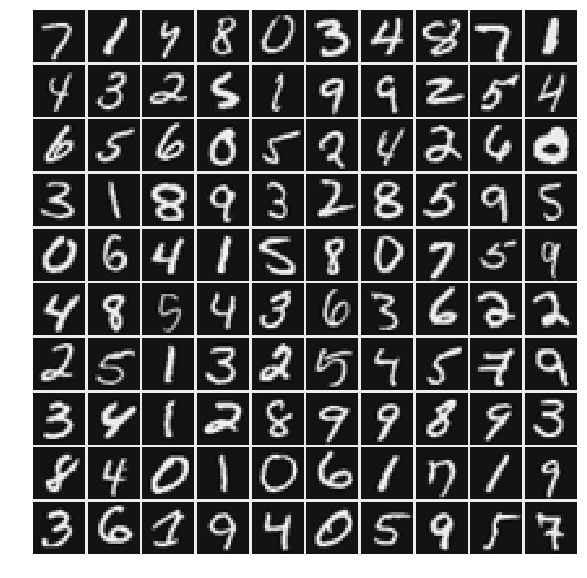

In [3]:
# Load all needed data
mat = scipy.io.loadmat('ex4data1.mat')
X = mat['X']
Y = mat['y']

weights = scipy.io.loadmat('ex4weights')
Theta1 = weights['Theta1']
Theta2 = weights['Theta2']

# Plot some examples
z = plot_numbers(X, 10, 5000)
plt.figure(figsize = (10,10))
plt.axis('off')
plt.imshow(z, cmap="gray");

In [4]:
# Let's do few tests

# We have to work on flatten data, because minimize funtion requires it.
t1 = Theta1.flatten('F')
t2 = Theta2.flatten('F')
T = np.concatenate((t1, t2))


layers = (400, 25, 10)
m = Y.shape[0]
Y_trans = np.zeros((10, m))
for k in range(m):
    Y_trans[Y[k] - 1,k] = 1 

    
lambda_ = 0
Jtest1, grad_test1  = gradient_cost_fun(T, X,Y_trans, lambda_, layers)

assert np.allclose(Jtest1, 0.287629)
assert np.allclose(grad_test1[:6],
                   np.array([6.1871e-05, 9.388e-05,-0.00019259,-0.00016849, 0.00034868,0.00023051]))

lambda_ = 1
Jtest2, grad_test2  = gradient_cost_fun(T, X,Y_trans, lambda_, layers)

assert np.allclose(Jtest2, 0.383770)
assert np.allclose(grad_test2[-6:],
                   np.array([-0.0010498, 0.00033512, -0.00064783, 0.00085755, 0.00093069, 0.00050783])
                  , rtol=10e-5, atol = 10e-8)

In [5]:
input_layer_size  = 400
# You can change hidden_layer_size only
hidden_layer_size = 25
num_labels = 10

# Randomly full our thetas (weights)
initial_Theta1_ori = random_init_thetas(input_layer_size, hidden_layer_size)
initial_Theta1 = initial_Theta1_ori.flatten('F')

initial_Theta2_ori = random_init_thetas(hidden_layer_size, num_labels)
initial_Theta2 = initial_Theta2_ori.flatten('F')
initial_Theta = np.concatenate((initial_Theta1, initial_Theta2)) 
# #units in next layers
layers = (input_layer_size, hidden_layer_size, num_labels)

lambda_ = 3
Nfeval = 1

cost_history = []
counter = 0

def callbackF(Xi):
    '''
    Gives callback information about last cost value and iteration number.
    '''
    global Nfeval
    print("Iteration:", Nfeval,"Cost:", cost_history[-1])
    Nfeval += 1

#Now minimize uses this same function for cost and grad (jac)!
res = minimize(gradient_cost_fun, initial_Theta, jac = True, args = (X, Y_trans, lambda_, layers),
               method = 'CG', callback=callbackF, options = {'maxiter' : 2000})

#Transform flat_array to list of array
thetas = pack(res.x, layers)
Theta1_min = thetas[0]
Theta2_min = thetas[1]

Iteration: 1 Cost: 3.41667053341
Iteration: 2 Cost: 3.24390595685
Iteration: 3 Cost: 2.95553790522
Iteration: 4 Cost: 2.4969484562
Iteration: 5 Cost: 2.2663074175
Iteration: 6 Cost: 2.0320250514
Iteration: 7 Cost: 1.78226963482
Iteration: 8 Cost: 1.50019711768
Iteration: 9 Cost: 1.44626992561
Iteration: 10 Cost: 1.37026693593
Iteration: 11 Cost: 1.29745303462
Iteration: 12 Cost: 1.24473807195
Iteration: 13 Cost: 1.15194442272
Iteration: 14 Cost: 1.06259379998
Iteration: 15 Cost: 1.01707678476
Iteration: 16 Cost: 0.980140034967
Iteration: 17 Cost: 0.9471541156
Iteration: 18 Cost: 0.927117145059
Iteration: 19 Cost: 0.891125099766
Iteration: 20 Cost: 0.869841830763
Iteration: 21 Cost: 0.853958140272
Iteration: 22 Cost: 0.83945157919
Iteration: 23 Cost: 0.827466334082
Iteration: 24 Cost: 0.820509323961
Iteration: 25 Cost: 0.80737489871
Iteration: 26 Cost: 0.794889707728
Iteration: 27 Cost: 0.784109882535
Iteration: 28 Cost: 0.772540265405
Iteration: 29 Cost: 0.757612283248
Iteration: 30 Co

Iteration: 235 Cost: 0.563725515397
Iteration: 236 Cost: 0.563685777623
Iteration: 237 Cost: 0.563634871038
Iteration: 238 Cost: 0.563583217166
Iteration: 239 Cost: 0.563522004174
Iteration: 240 Cost: 0.563432635811
Iteration: 241 Cost: 0.563338479175
Iteration: 242 Cost: 0.56318338114
Iteration: 243 Cost: 0.56306374931
Iteration: 244 Cost: 0.562941796026
Iteration: 245 Cost: 0.562858836561
Iteration: 246 Cost: 0.562781708634
Iteration: 247 Cost: 0.562663473594
Iteration: 248 Cost: 0.562475199375
Iteration: 249 Cost: 0.562402997007
Iteration: 250 Cost: 0.562331527842
Iteration: 251 Cost: 0.562268540217
Iteration: 252 Cost: 0.562209534997
Iteration: 253 Cost: 0.562151144885
Iteration: 254 Cost: 0.562109705588
Iteration: 255 Cost: 0.562067761363
Iteration: 256 Cost: 0.562044583472
Iteration: 257 Cost: 0.562009476885
Iteration: 258 Cost: 0.561935239462
Iteration: 259 Cost: 0.561847338915
Iteration: 260 Cost: 0.561781878867
Iteration: 261 Cost: 0.561715015243
Iteration: 262 Cost: 0.5615987

Iteration: 466 Cost: 0.556991423081
Iteration: 467 Cost: 0.556989918787
Iteration: 468 Cost: 0.556985652503
Iteration: 469 Cost: 0.556981280105
Iteration: 470 Cost: 0.556977457853
Iteration: 471 Cost: 0.556971904728
Iteration: 472 Cost: 0.556964821138
Iteration: 473 Cost: 0.556959868639
Iteration: 474 Cost: 0.556954810514
Iteration: 475 Cost: 0.556952027175
Iteration: 476 Cost: 0.556949957203
Iteration: 477 Cost: 0.556948143228
Iteration: 478 Cost: 0.556947203742
Iteration: 479 Cost: 0.556946296078
Iteration: 480 Cost: 0.556945226771
Iteration: 481 Cost: 0.556944526079
Iteration: 482 Cost: 0.556943743931
Iteration: 483 Cost: 0.556943060144
Iteration: 484 Cost: 0.556942265603
Iteration: 485 Cost: 0.556941582926
Iteration: 486 Cost: 0.556941000122
Iteration: 487 Cost: 0.556940114775
Iteration: 488 Cost: 0.556939548585
Iteration: 489 Cost: 0.556939205816
Iteration: 490 Cost: 0.556938581337
Iteration: 491 Cost: 0.556937978531
Iteration: 492 Cost: 0.556937335656
Iteration: 493 Cost: 0.55693

Iteration: 694 Cost: 0.556771606509
Iteration: 695 Cost: 0.556771253927
Iteration: 696 Cost: 0.556770853365
Iteration: 697 Cost: 0.5567704687
Iteration: 698 Cost: 0.556770186923
Iteration: 699 Cost: 0.556769805613
Iteration: 700 Cost: 0.556769486706
Iteration: 701 Cost: 0.556769207652
Iteration: 702 Cost: 0.556768418999
Iteration: 703 Cost: 0.556767659764
Iteration: 704 Cost: 0.556767118745
Iteration: 705 Cost: 0.556765749689
Iteration: 706 Cost: 0.556764281005
Iteration: 707 Cost: 0.556761995845
Iteration: 708 Cost: 0.556759679327
Iteration: 709 Cost: 0.556758239825
Iteration: 710 Cost: 0.556756369389
Iteration: 711 Cost: 0.556754637977
Iteration: 712 Cost: 0.556750559254
Iteration: 713 Cost: 0.556745491009
Iteration: 714 Cost: 0.556742876655
Iteration: 715 Cost: 0.556741755909
Iteration: 716 Cost: 0.55674055958
Iteration: 717 Cost: 0.556740190554
Iteration: 718 Cost: 0.556739701508
Iteration: 719 Cost: 0.556739587081
Iteration: 720 Cost: 0.556739494079
Iteration: 721 Cost: 0.55673939

Iteration: 927 Cost: 0.556335680088
Iteration: 928 Cost: 0.556334910413
Iteration: 929 Cost: 0.556334037538
Iteration: 930 Cost: 0.556333154264
Iteration: 931 Cost: 0.556332714317
Iteration: 932 Cost: 0.556332259135
Iteration: 933 Cost: 0.556331906745
Iteration: 934 Cost: 0.556331657757
Iteration: 935 Cost: 0.556331302687
Iteration: 936 Cost: 0.556330678751
Iteration: 937 Cost: 0.556330122848
Iteration: 938 Cost: 0.556329852033
Iteration: 939 Cost: 0.556329568152
Iteration: 940 Cost: 0.556329401378
Iteration: 941 Cost: 0.556329121503
Iteration: 942 Cost: 0.556328913839
Iteration: 943 Cost: 0.556328739712
Iteration: 944 Cost: 0.556328291586
Iteration: 945 Cost: 0.556327702129
Iteration: 946 Cost: 0.556327043182
Iteration: 947 Cost: 0.556326213407
Iteration: 948 Cost: 0.556325687434
Iteration: 949 Cost: 0.556325182737
Iteration: 950 Cost: 0.556324838122
Iteration: 951 Cost: 0.55632460596
Iteration: 952 Cost: 0.556324479206
Iteration: 953 Cost: 0.556324305826
Iteration: 954 Cost: 0.556324

In [6]:
print('Accuracy on training set =', 100*np.mean(predict(X, Theta1_min, Theta2_min) == Y),'proc')

Accuracy on training set = 97.78 proc


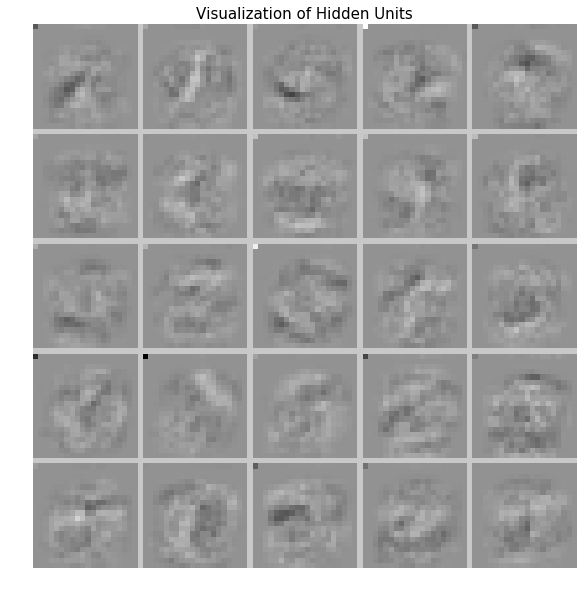

In [7]:
z1 = plot_numbers(Theta1_min, 5, 25)
plt.figure(figsize = (10,10))
plt.axis('off')
plt.imshow(z1, cmap="gray")
plt.title('Visualization of Hidden Units', size = 15);